# Methods

Starting a new notebook to address many of the thoughts in this comment: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413. 

This will likely include work to address:
- different ways to deal with boundaries when filtering
- a closer look into spice anomaly

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import funcs

In [2]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

### Idealized Profiles

This example is from Dhruv's notebooks over winter break (and more specifically the density-spice notebook).

In [3]:
L = 1000 # let's say units of m 
N = 500

alpha = 0
N2, z, dz = funcs.random_phase_power_law_function(alpha, N, L)
S, z, dz  = funcs.random_phase_power_law_function(3, N, L)
S = S/S.std()+36.5
N2 = (N2 + N2.max()+1) * 2e-4
rho = np.cumsum(N2) + 1020

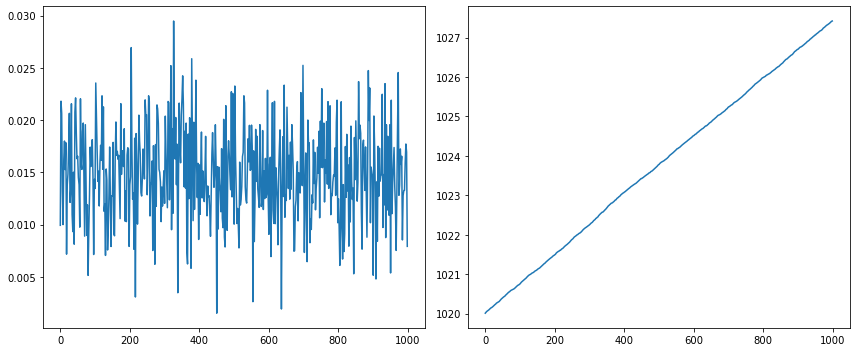

In [4]:
plt.figure(figsize= (12, 5))
plt.subplot(121)
plt.plot(z, N2)

plt.subplot(122)
plt.plot(z, rho)

plt.tight_layout()

In [5]:
T, _ = gsw.CT_from_rho(rho, S, 0)

spice = gsw.spiciness0(S, T)

In [6]:
profile = xr.Dataset(data_vars=dict(
                        CT=(['depth'],T),
                        SA=(['depth'],S),
                        SIG=(['depth'],rho),
                        SPICE=(['depth'], spice)
                        ),
                    coords=dict(
                        depth=z,)
                        )

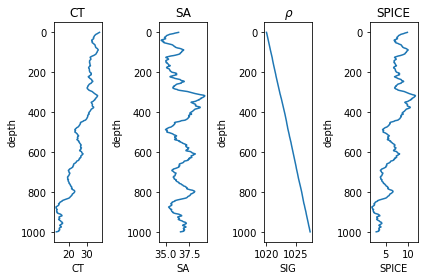

In [7]:
plt.subplot(141)
profile.CT.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
profile.SA.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
profile.SIG.plot(y='depth')
plt.gca().invert_yaxis()
plt.title(r'$\rho$')

plt.subplot(144)
profile.SPICE.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('SPICE')


plt.tight_layout()

### Boundaries

A few different approaches are possible here, a few of them are noted below:
- filter the whole profile
- filter the whole profile, then mask both boundaries (based on the filter scale)
- filter the whole profile, then mask the upper boundary (based on the mixed layer depth)
- select the profile below the mixed layer, then filter

First up, I'll need to get a handle on mixed layer datasets. Looking at the netcdf file with MLD for every argo profile here: http://mixedlayer.ucsd.edu/. It's a large file though (300+MB) so I have to figure out the best way to upload it here.

In [8]:
CT_filt_whole = ff.get_filt_prof(profile.CT,                                                     100,dim2='depth')
CT_filt_part  = ff.get_filt_prof(profile.CT.where(profile.depth>=100).where(profile.depth<=900), 100,dim2='depth')

In [9]:
filt = xr.Dataset(data_vars=dict(
                        CT       = (['depth'], T),
                        SA       = (['depth'], S),
                        SIG      = (['depth'], rho),
                        SPICE    = (['depth'], spice),
                        CT_whole = (['depth'], CT_filt_whole),
                        CT_part  = (['depth'], CT_filt_part)),
                    coords=dict(
                        depth=z,)
                        )

In [10]:
filt = filt.assign(CT_whole_mask = filt.CT_whole.where(profile.depth>=100).where(profile.depth<=900))
filt = filt.assign(CT_part_mask  = filt.CT_part.where (profile.depth>=200).where(profile.depth<=800))

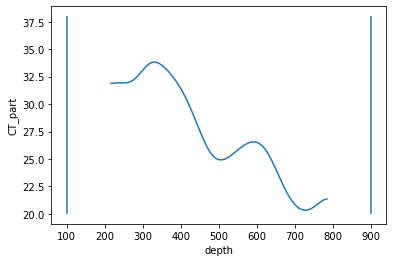

In [11]:
filt.CT_part.where(filt.depth>=100).where(filt.depth<=900).plot()
plt.vlines((100,900),20,38)

Text(0.5, 1.0, 'Filtered CT Profiles')

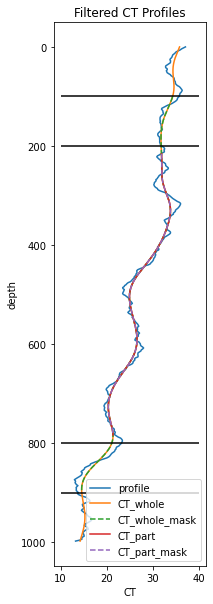

In [12]:
plt.figure(figsize=(6,10))
plt.subplot(122)
profile.CT.plot(y='depth',label='profile')

filt.CT_whole.plot(y='depth',label='CT_whole')
filt.CT_whole_mask.plot(y='depth',label='CT_whole_mask',linestyle='--')
plt.hlines([100,900],10,40,color='k')

filt.CT_part.plot(y='depth',label='CT_part')
filt.CT_part_mask.plot(y='depth',label='CT_part_mask',linestyle='--')
plt.hlines([200,800],10,40,color='k')

plt.gca().invert_yaxis()
plt.xlabel('CT')
plt.legend()
plt.title('Filtered CT Profiles')

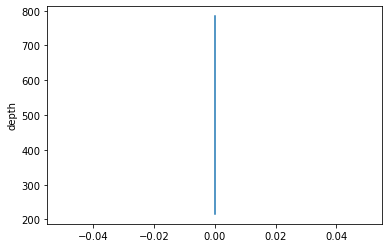

In [13]:
(filt.CT_whole - filt.CT_part).plot(y='depth')

This is strange. Proving the filter with a different profile (or in this case a different section of the same profile) should return a different filtered signal, right? Also, CT_part should be from depth (100,900) but it looks like closer to (200,800). Additionally, part_mask should be from depth (200,800), but it's not exactly on those lines.

All told, there's a lot to look at here, and I feel like I'm getting no where. Time to move on and circle back with a fresh mind.

### Spice Anomaly

Want to compare Dhruv's method (computing spice based on glider reference temperature) to my method (using the defaults in gsw, then calculating the anomaly). Does removing the mean impact the other metrics we are looking at?

In [14]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

xrft.power_spectrum() doesn't work properly when NaNs or missing data is present, so it's really not going to work on the density grid. I think the best thing is to calculate spice and SPICE on the depth grid too? Or maybe make the comparison plot on the depth grid instead of density?

In [36]:
n=0
mean_prof_z  = float_z.SPICE.isel(PRES_INTERPOLATED=n).mean(skipna=True)
spice_prof_z = float_z.SPICE.isel(PRES_INTERPOLATED=n) - mean_prof_z

for n in range(1,len(float_z.PRES_INTERPOLATED)):
    mean_prof_z       = float_z.SPICE.isel(PRES_INTERPOLATED=n).mean(skipna=True)
    spice_prof_next_z = float_z.SPICE.isel(PRES_INTERPOLATED=n) - mean_prof_z

    spice_prof_z = xr.concat([spice_prof_z, spice_prof_next_z], dim='PRES_INTERPOLATED')

In [38]:
alpha_z = gsw.alpha(float_z.SA, float_z.CT, float_z.PRES_INTERPOLATED)

dCT_z = float_z.CT - float_z.CT.mean('N_PROF')
float_z['spice']= 2*1000*alpha_z*dCT_z

In [107]:
zdiff = float_z.spice - spice_prof_z

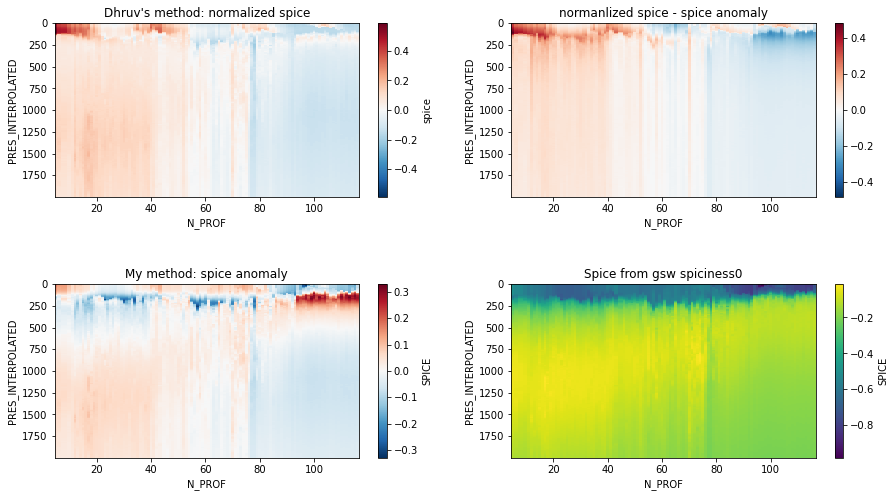

In [109]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_z.spice.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
zdiff.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("normanlized spice - spice anomaly")

plt.subplot(2,2,3)
spice_prof_z.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("My method: spice anomaly")

plt.subplot(2,2,4)
float_z.SPICE.plot(y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()
plt.title("Spice from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)

In [158]:
spice_spec_z = xrft.power_spectrum(float_z.spice,dim='PRES_INTERPOLATED', window=True)
SPICE_spec_z = xrft.power_spectrum(spice_prof_z ,dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [159]:
spice_spec_mean_z = xrft.power_spectrum(float_z.spice - float_z.spice.mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)
SPICE_spec_mean_z = xrft.power_spectrum(spice_prof_z  - spice_prof_z .mean('N_PROF'),dim='PRES_INTERPOLATED', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


Text(0.5, 1.0, 'plot 1 - plot 2')

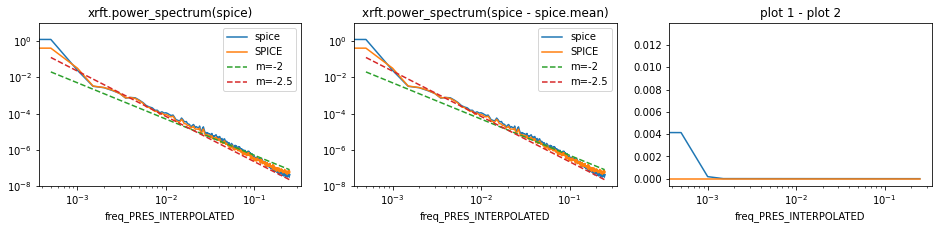

In [160]:
plt.figure(figsize=(16,3))

plt.subplot(1,3,1)
spice_spec_z.mean('N_PROF').plot(label='spice')
SPICE_spec_z.mean('N_PROF').plot(label='SPICE')

kz = spice_spec_z.freq_PRES_INTERPOLATED
plt.plot(kz, 5e-9*kz**(-2), '--', label='m=-2')
plt.plot(kz, 7e-10*kz**(-2.5), '--', label='m=-2.5')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1e1)
plt.legend()
plt.title('xrft.power_spectrum(spice)')

plt.subplot(1,3,2)
spice_spec_mean_z.mean('N_PROF').plot(label='spice')
SPICE_spec_mean_z.mean('N_PROF').plot(label='SPICE')

kz = spice_spec_mean_z.freq_PRES_INTERPOLATED
plt.plot(kz, 5e-9*kz**(-2), '--', label='m=-2')
plt.plot(kz, 7e-10*kz**(-2.5), '--', label='m=-2.5')

plt.ylim(1e-8, 1e1)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('xrft.power_spectrum(spice - spice.mean)')


plt.subplot(1,3,3)
(spice_spec_z - spice_spec_mean_z).mean('N_PROF').plot(label='spice')
(SPICE_spec_z - SPICE_spec_mean_z).mean('N_PROF').plot(label='SPICE')

plt.xscale('log')
plt.title('plot 1 - plot 2')

This compares the method of taking the power_spectrum of just spice to the mean spice subtracted from spice. It seems like the only effect this has is in the larger filter scale side of the spectrum and only for the method with a reference temperature gradient. This probably makes sense because in my method, the large scale signals have already been removed, so this has less of an effect. I think the next step is to see if (how?) this effects individual lines, not just the .mean('N_PROF') which is plotted here.

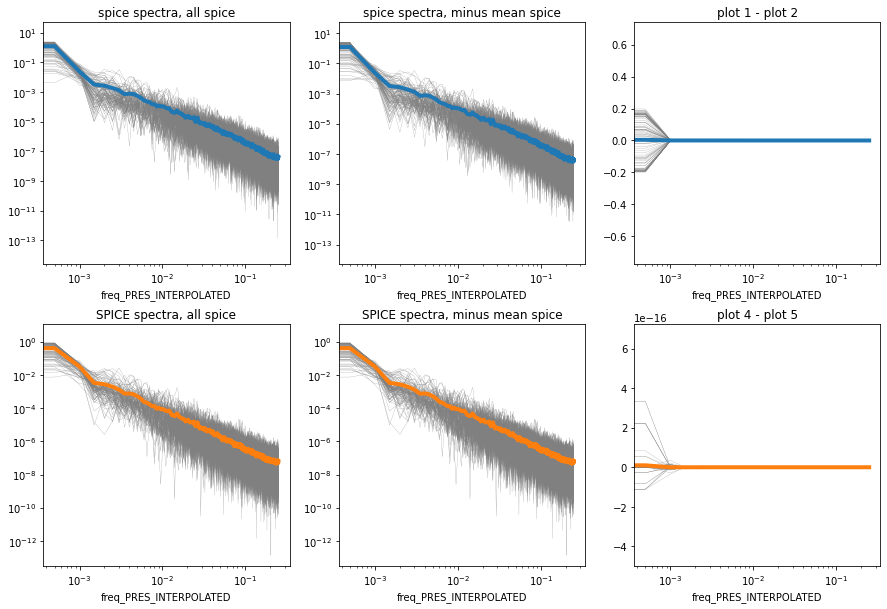

In [172]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
for n in range(0, len(spice_spec_z.N_PROF)):
    spice_spec_z.isel(N_PROF=n).plot(color='gray',linewidth=0.2)
spice_spec_z.mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('spice spectra, all spice')

plt.subplot(2,3,2)
for n in range(0, len(spice_spec_mean_z.N_PROF)):
    spice_spec_mean_z.isel(N_PROF=n).plot(color='gray',linewidth=0.2)
spice_spec_mean_z.mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('spice spectra, minus mean spice')

plt.subplot(2,3,3)
for n in range(0, len(spice_spec_z.N_PROF)):
    (spice_spec_z.isel(N_PROF=n) - spice_spec_mean_z.isel(N_PROF=n)).plot(color='gray',linewidth=0.2)
(spice_spec_z - spice_spec_mean_z).mean('N_PROF').plot(color='tab:blue',linewidth=4)
plt.xscale('log')
plt.title('plot 1 - plot 2')

plt.subplot(2,3,4)
for i in range(0, len(SPICE_spec_z.N_PROF)):
    SPICE_spec_z.isel(N_PROF=i).plot(color='gray',linewidth=0.2)
SPICE_spec_z.mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('SPICE spectra, all spice')

plt.subplot(2,3,5)
for i in range(0, len(SPICE_spec_mean_z.N_PROF)):
    SPICE_spec_mean_z.isel(N_PROF=i).plot(color='gray',linewidth=0.2)
SPICE_spec_mean_z.mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.title('SPICE spectra, minus mean spice')

plt.subplot(2,3,6)
for n in range(0, len(spice_spec_z.N_PROF)):
    (SPICE_spec_z.isel(N_PROF=n) - SPICE_spec_mean_z.isel(N_PROF=n)).plot(color='gray',linewidth=0.2)
(SPICE_spec_z - SPICE_spec_mean_z).mean('N_PROF').plot(color='tab:orange',linewidth=4)
plt.xscale('log')
plt.title('plot 4 - plot 5')

plt.subplots_adjust(hspace=0.25)

In [149]:
n=0
mean_prof_r  = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
spice_prof_r = float_r.SPICE.isel(rho_grid=n) - mean_prof_r

for n in range(1,len(float_r.rho_grid)):
    mean_prof_r       = float_r.SPICE.isel(rho_grid=n).mean(skipna=True)
    spice_prof_next_r = float_r.SPICE.isel(rho_grid=n) - mean_prof_r

    spice_prof_r = xr.concat([spice_prof_r, spice_prof_next_r], dim='rho_grid')

In [150]:
alpha_r = gsw.alpha(float_r.SA, float_r.CT, float_r.PRES_INTERPOLATED)

dCT_r = float_r.CT - float_r.CT.mean('N_PROF_NEW')
float_r['spice']= 2*1000*alpha_r*dCT_r

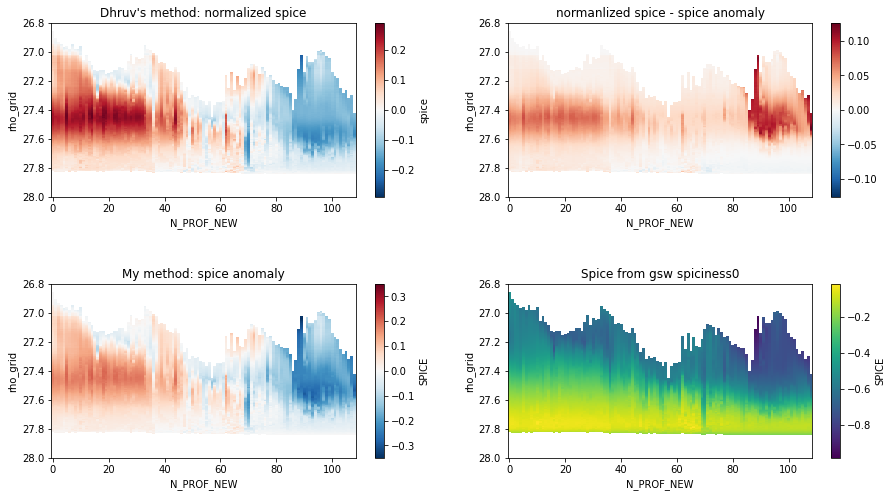

In [151]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
float_r.spice.plot()
plt.gca().invert_yaxis()
plt.title("Dhruv's method: normalized spice")

plt.subplot(2,2,2)
(float_r.spice - spice_prof_r).plot()
plt.gca().invert_yaxis()
plt.title("normanlized spice - spice anomaly")

plt.subplot(2,2,3)
spice_prof_r.plot()
plt.gca().invert_yaxis()
plt.title("My method: spice anomaly")

plt.subplot(2,2,4)
float_r.SPICE.plot()
plt.gca().invert_yaxis()
plt.title("Spice from gsw spiciness0")

plt.subplots_adjust(hspace=0.5)

In [152]:
spice_spec_r = xrft.power_spectrum(float_r.spice.dropna(dim='N_PROF_NEW') - float_r.spice.mean('N_PROF_NEW'),dim='rho_grid', window=True)
SPICE_spec_r = xrft.power_spectrum(spice_prof_r.dropna(dim='N_PROF_NEW')  - spice_prof_r .mean('N_PROF_NEW'),dim='rho_grid', window=True)

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


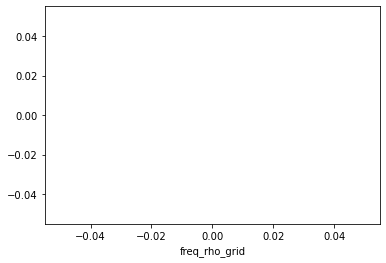

In [136]:
spice_spec_r.mean('N_PROF_NEW').plot()
SPICE_spec_r.mean('N_PROF_NEW').plot()